# 02 - Random Forest Classifier

## Diabetic Foot Ulcer Risk Classification - Primary Model

This notebook trains a Random Forest classifier for early diabetic foot ulcer detection using multi-sensor wearable data.

### Objectives:
- Preprocess data with feature engineering
- Train Random Forest classifier
- Evaluate model performance
- Export model as .pkl and .tflite for mobile deployment

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

print(" Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Dataset

In [ ]:
# Load the dataset
DATA_PATH = '../Synthetic_Data/synthetic_foot_ulcer_dataset_RISK.csv'
df = pd.read_csv(DATA_PATH)

print(f" Dataset loaded: {df.shape[0]} samples × {df.shape[1]} columns")
df.head()

✅ Dataset loaded: 10000 samples × 20 columns


,temp_heel,press_heel,temp_ball,press_ball,temp_arch,press_arch,temp_toe,press_toe,spo2,heartRate,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,stepCount,batteryLevel,risk_score,label
0,33.498160,58.028572,34.927976,43.946339,32.624075,26.239781,32.232334,54.647046,95.621089,81,0.239495,-0.478550,9.866665,-34.223433,-42.545393,-9.398040,59,99,0.378454,0
1,32.931085,23.624257,34.473544,35.298480,35.932924,38.670516,35.439762,47.212302,85.198974,119,-6.080159,3.358271,12.137578,-88.087821,90.418256,29.849513,34,97,0.693139,1
2,33.564242,27.289444,35.021446,37.006235,32.831767,42.708013,32.125253,53.691391,90.927254,73,-2.721560,3.565877,12.156596,212.480807,21.078883,131.341689,23,45,0.555218,0
3,35.861021,44.281370,33.103997,31.850940,40.354115,105.342867,33.693606,35.795261,95.935108,92,2.095321,0.520806,11.786854,19.289773,-13.456407,93.181492,32,67,0.662824,1
4,33.483273,46.753650,34.663689,43.651912,33.098887,42.449737,33.531707,58.868484,95.825943,73,10.116889,-2.761172,8.604085,-4.869127,-113.500037,83.399329,95,23,0.388919,0


## 2. Feature Definition

### Features to INCLUDE:
- Temperature sensors (4): temp_heel, temp_ball, temp_arch, temp_toe
- Pressure sensors (4): press_heel, press_ball, press_arch, press_toe
- Vital signs (2): spo2, heartRate
- Motion sensors (6): acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z
- Activity (1): stepCount

### Features to EXCLUDE:
- `batteryLevel`: System-level feature
- `risk_score`: Model output, NOT input

In [3]:
# Define feature groups
TEMP_FEATURES = ['temp_heel', 'temp_ball', 'temp_arch', 'temp_toe']
PRESSURE_FEATURES = ['press_heel', 'press_ball', 'press_arch', 'press_toe']
VITAL_FEATURES = ['spo2', 'heartRate']
ACC_FEATURES = ['acc_x', 'acc_y', 'acc_z']
GYRO_FEATURES = ['gyro_x', 'gyro_y', 'gyro_z']
ACTIVITY_FEATURES = ['stepCount']

# All raw sensor features
RAW_SENSOR_FEATURES = (TEMP_FEATURES + PRESSURE_FEATURES + VITAL_FEATURES + 
                       ACC_FEATURES + GYRO_FEATURES + ACTIVITY_FEATURES)

# Target column
TARGET = 'label'

print(f"Raw sensor features ({len(RAW_SENSOR_FEATURES)}): {RAW_SENSOR_FEATURES}")

Raw sensor features (17): ['temp_heel', 'temp_ball', 'temp_arch', 'temp_toe', 'press_heel', 'press_ball', 'press_arch', 'press_toe', 'spo2', 'heartRate', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'stepCount']


## 3. Feature Engineering

In [ ]:
# Create a copy for feature engineering
df_processed = df.copy()

# =============================================================================
# ENGINEERED FEATURES
# =============================================================================

# Pressure features
df_processed['max_pressure'] = df_processed[PRESSURE_FEATURES].max(axis=1)
df_processed['pressure_variance'] = df_processed[PRESSURE_FEATURES].var(axis=1)

# Temperature features
df_processed['max_temp'] = df_processed[TEMP_FEATURES].max(axis=1)
df_processed['temp_variance'] = df_processed[TEMP_FEATURES].var(axis=1)

# Motion magnitude features
df_processed['acc_magnitude'] = np.sqrt(
    df_processed['acc_x']**2 + 
    df_processed['acc_y']**2 + 
    df_processed['acc_z']**2
)

df_processed['gyro_magnitude'] = np.sqrt(
    df_processed['gyro_x']**2 + 
    df_processed['gyro_y']**2 + 
    df_processed['gyro_z']**2
)

# Define engineered features
ENGINEERED_FEATURES = [
    'max_pressure', 'pressure_variance',
    'max_temp', 'temp_variance',
    'acc_magnitude', 'gyro_magnitude'
]

print(f"Engineered features created: {ENGINEERED_FEATURES}")
df_processed[ENGINEERED_FEATURES].describe()

✅ Engineered features created: ['max_pressure', 'pressure_variance', 'max_temp', 'temp_variance', 'acc_magnitude', 'gyro_magnitude']


,max_pressure,pressure_variance,max_temp,temp_variance,acc_magnitude,gyro_magnitude
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,64.596223,359.000757,36.376418,3.301407,10.671380,127.558684
std,21.680199,431.893589,1.989464,3.612137,2.822650,53.745618
min,24.814384,0.256188,32.280170,0.002370,1.174682,4.907324
25%,50.888792,92.210175,35.082359,0.899668,8.763291,88.603606
50%,56.688439,175.441829,35.664349,1.729986,10.611316,123.028521
75%,76.954200,417.771393,37.997981,4.628611,12.573150,161.748950
max,119.986875,2236.700968,40.996875,17.289692,21.509454,394.913082


In [5]:
# Combine all features for model
ALL_FEATURES = RAW_SENSOR_FEATURES + ENGINEERED_FEATURES

print(f"\n{'='*80}")
print("FINAL FEATURE SET FOR MODEL TRAINING")
print(f"{'='*80}")
print(f"\nTotal features: {len(ALL_FEATURES)}")
print(f"\nRaw sensor features ({len(RAW_SENSOR_FEATURES)}):")
for i, f in enumerate(RAW_SENSOR_FEATURES, 1):
    print(f"  {i:2d}. {f}")
    
print(f"\nEngineered features ({len(ENGINEERED_FEATURES)}):")
for i, f in enumerate(ENGINEERED_FEATURES, 1):
    print(f"  {i:2d}. {f}")


FINAL FEATURE SET FOR MODEL TRAINING

Total features: 23

Raw sensor features (17):
   1. temp_heel
   2. temp_ball
   3. temp_arch
   4. temp_toe
   5. press_heel
   6. press_ball
   7. press_arch
   8. press_toe
   9. spo2
  10. heartRate
  11. acc_x
  12. acc_y
  13. acc_z
  14. gyro_x
  15. gyro_y
  16. gyro_z
  17. stepCount

Engineered features (6):
   1. max_pressure
   2. pressure_variance
   3. max_temp
   4. temp_variance
   5. acc_magnitude
   6. gyro_magnitude


## 4. Prepare Features and Target

In [6]:
# Separate features (X) and target (y)
X = df_processed[ALL_FEATURES].copy()
y = df_processed[TARGET].copy()

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())

Feature matrix X shape: (10000, 23)
Target vector y shape: (10000,)

Class distribution:
label
0    6692
1    3308
Name: count, dtype: int64


In [7]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

Training set: 8000 samples
Test set: 2000 samples

Training class distribution:
label
0    5354
1    2646
Name: count, dtype: int64

Test class distribution:
label
0    1338
1     662
Name: count, dtype: int64


## 5. Feature Scaling

In [8]:
# Initialize and fit scaler
scaler = StandardScaler()

# Fit on training data only, transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=ALL_FEATURES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=ALL_FEATURES)

print("✅ Features scaled using StandardScaler")
print("\nScaled training data statistics:")
print(X_train_scaled_df.describe().loc[['mean', 'std']].round(4))

✅ Features scaled using StandardScaler

Scaled training data statistics:
      temp_heel  temp_ball  temp_arch  temp_toe  press_heel  press_ball  \
mean     0.0000     0.0000    -0.0000    0.0000     -0.0000      0.0000   
std      1.0001     1.0001     1.0001    1.0001      1.0001      1.0001   

      press_arch  press_toe    spo2  heartRate  ...  gyro_x  gyro_y  gyro_z  \
mean     -0.0000     0.0000  0.0000     0.0000  ... -0.0000  0.0000  0.0000   
std       1.0001     1.0001  1.0001     1.0001  ...  1.0001  1.0001  1.0001   

      stepCount  max_pressure  pressure_variance  max_temp  temp_variance  \
mean    -0.0000        0.0000             0.0000    0.0000         0.0000   
std      1.0001        1.0001             1.0001    1.0001         1.0001   

      acc_magnitude  gyro_magnitude  
mean         0.0000          0.0000  
std          1.0001          1.0001  

[2 rows x 23 columns]


## 6. Train Random Forest Classifier

In [9]:
# Initialize Random Forest with class balancing
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Train the model
print("Training Random Forest classifier...")
rf_model.fit(X_train_scaled, y_train)
print("✅ Model training complete!")

Training Random Forest classifier...
✅ Model training complete!


In [10]:
# Cross-validation score
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS (5-Fold)")
print(f"{'='*80}")
print(f"ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


CROSS-VALIDATION RESULTS (5-Fold)
ROC-AUC scores: [0.98544017 0.98699165 0.9858885  0.98580201 0.98457415]
Mean ROC-AUC: 0.9857 (+/- 0.0016)


## 7. Model Evaluation

In [11]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'='*80}")
print("MODEL EVALUATION METRICS")
print(f"{'='*80}")
print(f"\n  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")


MODEL EVALUATION METRICS

  Accuracy:  0.9365
  Precision: 0.9122
  Recall:    0.8943
  F1-Score:  0.9031
  ROC-AUC:   0.9861


In [12]:
# Classification report
print(f"\n{'='*80}")
print("CLASSIFICATION REPORT")
print(f"{'='*80}")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'High Risk (1)']))


CLASSIFICATION REPORT
               precision    recall  f1-score   support

   Normal (0)       0.95      0.96      0.95      1338
High Risk (1)       0.91      0.89      0.90       662

     accuracy                           0.94      2000
    macro avg       0.93      0.93      0.93      2000
 weighted avg       0.94      0.94      0.94      2000



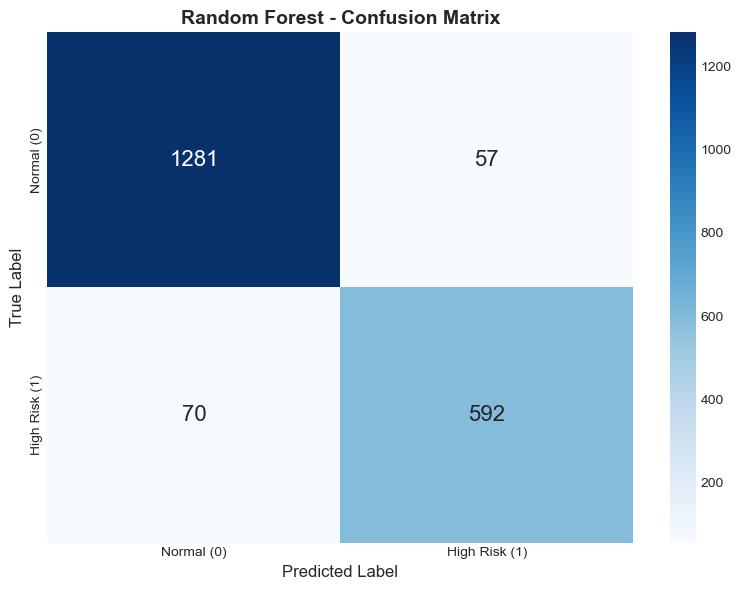

📊 Plot saved: plots/rf_confusion_matrix.png


In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (0)', 'High Risk (1)'],
            yticklabels=['Normal (0)', 'High Risk (1)'],
            annot_kws={'size': 16}, ax=ax)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Plot saved: plots/rf_confusion_matrix.png")

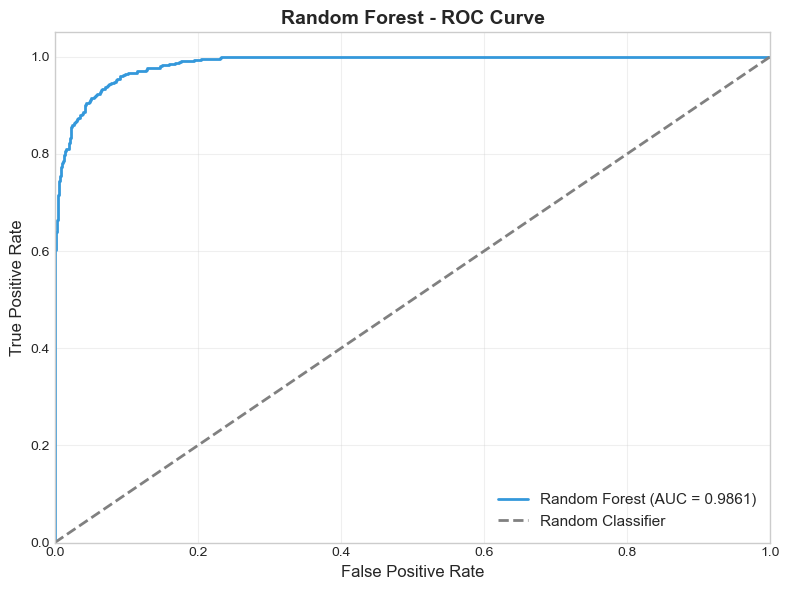

📊 Plot saved: plots/rf_roc_curve.png


In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='#3498db', lw=2, label=f'Random Forest (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Random Forest - ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/rf_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Plot saved: plots/rf_roc_curve.png")

## 8. Feature Importance

In [15]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': ALL_FEATURES,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE RANKING")
print(f"{'='*80}")
print(feature_importance.to_string(index=False))


FEATURE IMPORTANCE RANKING
          feature  importance
             spo2    0.264151
         max_temp    0.135052
    temp_variance    0.122346
     max_pressure    0.103331
pressure_variance    0.075936
        stepCount    0.061811
    acc_magnitude    0.028556
            acc_z    0.024198
        press_toe    0.019838
         temp_toe    0.019258
        temp_ball    0.018648
        temp_arch    0.018071
       press_arch    0.017424
       press_heel    0.016360
        temp_heel    0.014588
       press_ball    0.014097
            acc_y    0.007116
            acc_x    0.007114
   gyro_magnitude    0.007004
           gyro_y    0.006621
           gyro_z    0.006330
           gyro_x    0.006231
        heartRate    0.005918


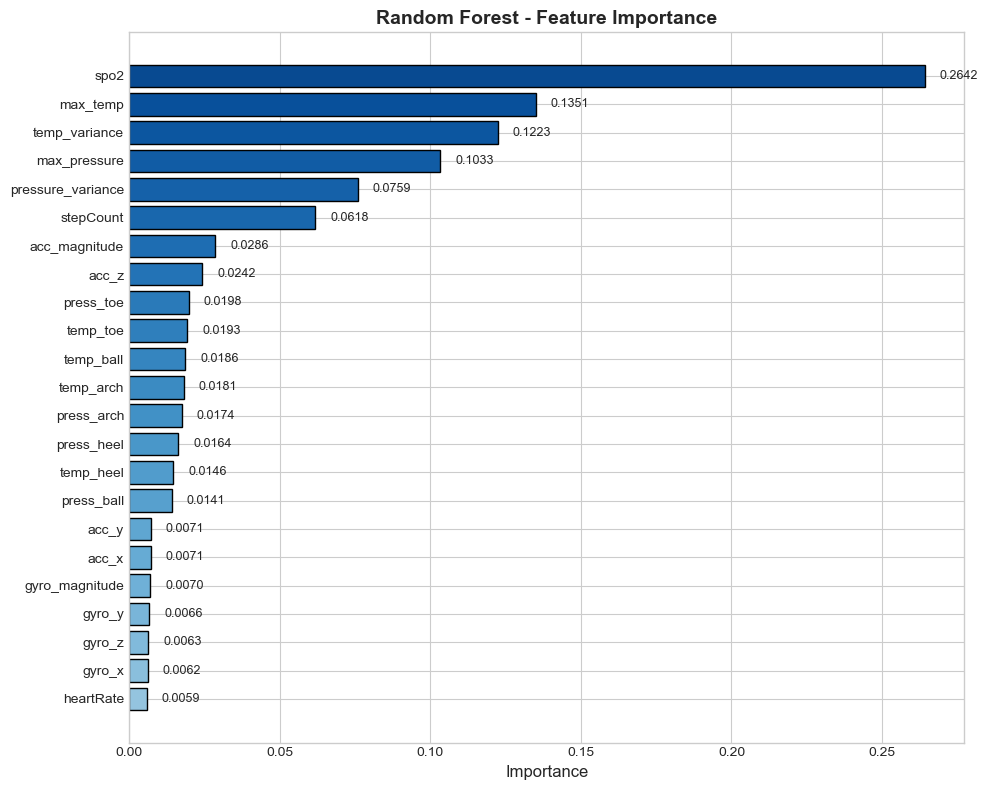

📊 Plot saved: plots/rf_feature_importance.png


In [16]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(feature_importance)))
bars = ax.barh(feature_importance['feature'], feature_importance['importance'], 
               color=colors[::-1], edgecolor='black')

ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, feature_importance['importance']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('plots/rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Plot saved: plots/rf_feature_importance.png")

## 9. Save Model (.pkl)

In [17]:
# Save the trained model
MODEL_PATH = 'models/random_forest_model.pkl'
joblib.dump(rf_model, MODEL_PATH)
print(f"✅ Model saved: {MODEL_PATH}")

# Save the scaler
SCALER_PATH = 'models/scaler.pkl'
joblib.dump(scaler, SCALER_PATH)
print(f"✅ Scaler saved: {SCALER_PATH}")

# Save feature list
FEATURES_PATH = 'models/feature_names.pkl'
joblib.dump(ALL_FEATURES, FEATURES_PATH)
print(f"✅ Feature names saved: {FEATURES_PATH}")

✅ Model saved: models/random_forest_model.pkl
✅ Scaler saved: models/scaler.pkl
✅ Feature names saved: models/feature_names.pkl


## 10. TensorFlow Lite Conversion

Random Forest models need to be converted to TensorFlow format first, then to TFLite.

In [19]:
# Import TensorFlow
%pip install tensorflow
import tensorflow as tf
from tensorflow import keras

print(f"TensorFlow version: {tf.__version__}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 1.3/331.9 MB 7.4 MB/s eta 0:00:45
   ---------------------------------------- 2.9/331.9 MB 7.6 MB/s eta 0:00:44
    --------------------------------------- 4.5/331.9 MB 7.1 MB/s eta 0:00:47
    --------------------------------------- 5.5/331.9 MB 6.7 MB/s eta 0:00:49
    --------------------------------------- 6.6/331.9 MB 6.3 MB/s eta 0:00:52
    --------------------------------------- 7.3/331.9 MB 6.0 MB/s eta 0:00:54
   - ---------------

In [20]:
# Create a Neural Network that mimics the Random Forest behavior
# Train it to match RF predictions for TFLite deployment

# Use RF predictions as soft labels for knowledge distillation
rf_train_proba = rf_model.predict_proba(X_train_scaled)[:, 1]

# Build a simple neural network
nn_model = keras.Sequential([
    keras.layers.Input(shape=(len(ALL_FEATURES),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the neural network on original labels
print("Training Neural Network for TFLite conversion...")

history = nn_model.fit(
    X_train_scaled, 
    y_train.values,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

print("✅ Neural Network training complete!")

Training Neural Network for TFLite conversion...
✅ Neural Network training complete!


In [22]:
# Evaluate NN model
nn_pred_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()
nn_pred = (nn_pred_proba >= 0.5).astype(int)

nn_accuracy = accuracy_score(y_test, nn_pred)
nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)

print(f"\n{'='*80}")
print("NEURAL NETWORK EVALUATION (for TFLite)")
print(f"{'='*80}")
print(f"  Accuracy: {nn_accuracy:.4f}")
print(f"  ROC-AUC:  {nn_roc_auc:.4f}")


NEURAL NETWORK EVALUATION (for TFLite)
  Accuracy: 0.9505
  ROC-AUC:  0.9919


In [23]:
# Save the Keras model
KERAS_MODEL_PATH = 'models/rf_neural_network.keras'
nn_model.save(KERAS_MODEL_PATH)
print(f"✅ Keras model saved: {KERAS_MODEL_PATH}")

✅ Keras model saved: models/rf_neural_network.keras


In [24]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(nn_model)

# Optimization for mobile
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert
tflite_model = converter.convert()

# Save TFLite model
TFLITE_PATH = 'models/random_forest_model.tflite'
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite model saved: {TFLITE_PATH}")
print(f"   Model size: {len(tflite_model) / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp3u3mznmb\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp3u3mznmb\assets


Saved artifact at 'C:\Users\HP\AppData\Local\Temp\tmp3u3mznmb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 23), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2270665519184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2270665520720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2270665521296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2270665520336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2270665520144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2270665521488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2270665522256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2270665519952: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model saved: models/random_forest_model.tflite
   Model size: 11.50 KB


In [25]:
# Verify TFLite model
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n{'='*80}")
print("TFLITE MODEL VERIFICATION")
print(f"{'='*80}")
print(f"\nInput shape: {input_details[0]['shape']}")
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output type: {output_details[0]['dtype']}")


TFLITE MODEL VERIFICATION

Input shape: [ 1 23]
Input type: <class 'numpy.float32'>
Output shape: [1 1]
Output type: <class 'numpy.float32'>


In [26]:
# Test TFLite inference
def tflite_predict(interpreter, input_data):
    """Run inference on TFLite model"""
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
    interpreter.invoke()
    
    return interpreter.get_tensor(output_details[0]['index'])

# Test with a sample
sample = X_test_scaled[:1].astype(np.float32)
tflite_output = tflite_predict(interpreter, sample)

print(f"\nSample TFLite inference:")
print(f"  Input shape: {sample.shape}")
print(f"  Output (risk probability): {tflite_output[0][0]:.4f}")
print(f"  Predicted class: {'High Risk' if tflite_output[0][0] >= 0.5 else 'Normal'}")


Sample TFLite inference:
  Input shape: (1, 23)
  Output (risk probability): 0.0000
  Predicted class: Normal


## 11. Inference Example (Risk Score Generation)

In [27]:
# Demonstrate how to generate risk score from model output
print(f"\n{'='*80}")
print("RISK SCORE GENERATION EXAMPLE")
print(f"{'='*80}")

# Get predictions from Random Forest
sample_indices = [0, 5, 10, 15, 20]
sample_data = X_test_scaled[sample_indices]

# Risk score = probability of class 1 (High Risk)
risk_scores = rf_model.predict_proba(sample_data)[:, 1]
predicted_classes = rf_model.predict(sample_data)
actual_classes = y_test.iloc[sample_indices].values

print("\nSample predictions:")
print("-" * 60)
print(f"{'Index':<10} {'Risk Score':<15} {'Predicted':<15} {'Actual':<10}")
print("-" * 60)

for i, (idx, rs, pred, actual) in enumerate(zip(sample_indices, risk_scores, predicted_classes, actual_classes)):
    pred_label = 'High Risk' if pred == 1 else 'Normal'
    actual_label = 'High Risk' if actual == 1 else 'Normal'
    print(f"{idx:<10} {rs:<15.4f} {pred_label:<15} {actual_label:<10}")

print("\n📝 Note: Risk score is the model's probabilistic output (0.0 - 1.0)")
print("   - < 0.3: Low risk")
print("   - 0.3 - 0.6: Moderate risk")
print("   - > 0.6: High risk")


RISK SCORE GENERATION EXAMPLE

Sample predictions:
------------------------------------------------------------
Index      Risk Score      Predicted       Actual    
------------------------------------------------------------
0          0.0160          Normal          Normal    
5          0.0238          Normal          Normal    
10         0.0347          Normal          Normal    
15         0.9213          High Risk       High Risk 
20         0.0731          Normal          Normal    

📝 Note: Risk score is the model's probabilistic output (0.0 - 1.0)
   - < 0.3: Low risk
   - 0.3 - 0.6: Moderate risk
   - > 0.6: High risk


## 12. Summary

In [28]:
print(f"\n{'='*80}")
print("RANDOM FOREST MODEL - TRAINING COMPLETE")
print(f"{'='*80}")

print(f"\n📊 Model Performance:")
print(f"   - Accuracy:  {accuracy:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall:    {recall:.4f}")
print(f"   - F1-Score:  {f1:.4f}")
print(f"   - ROC-AUC:   {roc_auc:.4f}")

print(f"\n📁 Saved Files:")
print(f"   - models/random_forest_model.pkl (Original RF model)")
print(f"   - models/scaler.pkl (StandardScaler)")
print(f"   - models/feature_names.pkl (Feature list)")
print(f"   - models/rf_neural_network.keras (Keras model)")
print(f"   - models/random_forest_model.tflite (TFLite model)")

print(f"\n📈 Plots:")
print(f"   - plots/rf_confusion_matrix.png")
print(f"   - plots/rf_roc_curve.png")
print(f"   - plots/rf_feature_importance.png")

print(f"\n✅ Random Forest pipeline complete!")


RANDOM FOREST MODEL - TRAINING COMPLETE

📊 Model Performance:
   - Accuracy:  0.9365
   - Precision: 0.9122
   - Recall:    0.8943
   - F1-Score:  0.9031
   - ROC-AUC:   0.9861

📁 Saved Files:
   - models/random_forest_model.pkl (Original RF model)
   - models/scaler.pkl (StandardScaler)
   - models/feature_names.pkl (Feature list)
   - models/rf_neural_network.keras (Keras model)
   - models/random_forest_model.tflite (TFLite model)

📈 Plots:
   - plots/rf_confusion_matrix.png
   - plots/rf_roc_curve.png
   - plots/rf_feature_importance.png

✅ Random Forest pipeline complete!
